In [2]:
import sys
sys.path.append("../")
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_algorithms.optimizers import SPSA
from sanchez_ansatz import SanchezAnsatz
from experiments.experiment_module import ExperimentModule
from experiments.create_state import get_state
from experiments.densities import compute_eta
from experiments.util import get_state_vector
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
class ReplicateOptModule: 
    
    def __init__(self, ansatz: QuantumCircuit, k0: int, init_params: np.ndarray, target_state: np.ndarray, learning_rate: float = 1.5, tol: float=1e-9):
        self._ansatz = ansatz
        self._num_qubits = ansatz.num_qubits
        self._init_params = init_params
        self._target_state = target_state
        self._learning_rate = learning_rate
        self._k0 = k0
        self._tol = tol
        
    def _compute_state_vector(self, params):
        temp_ansatz = self._ansatz.assign_parameters(params)
        return get_state_vector(temp_ansatz)
    
    def loss(output_state: np.ndarray ,target_state: np.ndarray): 
        return np.mean((output_state - target_state)**2)
    
    def _compute_partial(self, out_amp: float, amp_idx: int, param: float, param_idx: int, param_lvl: int):
        """
        Equation (34) from  MARIN-SANCHEZ et al. (2021) arXiv:2111.07933

        Returns:
            float: the result of the partial
        """
        condition_1_1 = param_idx*2**(self._num_qubits - param_lvl + 1) <= amp_idx
        condition_1_2 = amp_idx < (param_idx + 1)*2**(self._num_qubits - param_lvl)
        
        condition_2_1 = (param_idx+1)*2**(self._num_qubits - param_lvl) <= amp_idx
        condition_2_2 = amp_idx < (param_idx+1)*2**(self._num_qubits - param_lvl + 1)
        
        if  condition_1_1 and condition_1_2:
            return -1/2 * np.sin(param/2)/np.cos(param/2) * out_amp
        if condition_2_1 and condition_2_2:
            return 1/2 * np.cos(param/2)/np.sin(param/2) * out_amp
        
        return 0
    
    def _loss_partial(self, output_state: np.ndarray, targ_state: np.ndarray, param: float, param_idx: int, param_lvl):
        diffs = []
        for amp_idx, (out_amp, targ_amp) in enumerate(zip(output_state, targ_state)):
            diff = 2*(out_amp - targ_amp)*self._compute_partial(out_amp, amp_idx, param, param_idx, param_lvl)
            diffs.append(diff)

        return np.mean(diff)
        
    def _opt_step(self, params: np.ndarray, output_state, targ_state)->np.ndarray:
        
        
        
        loss_derivatives = np.zeros((len(params),))
        for param_idx, param in enumerate(params):
            loss_derivatives[param_idx] = self._loss_partial(output_state, targ_state, param, param_idx, )
        
        return loss_derivatives
        
        

### Normal distribution

In [4]:
interval = (0, 1) 
num_qubits = 8

scales = [1, 0.6, 0.4, 0.3]

target_states = []
approx_states = []

for scale in scales:

    state_params = {"x_points": interval, "loc": 0.5, "scale": scale}

    normal_amplitudes = get_state(num_qubits, "normal", state_params)
    eta = compute_eta("normal", density_params=state_params)

    sanchez = SanchezAnsatz(normal_amplitudes, eps=0.05, eta=eta)
    init_params = sanchez.init_params
    t_sanchez = transpile(sanchez, basis_gates=["u", "cx"])

    em = ExperimentModule(t_sanchez, SPSA(maxiter=3000), target_state=normal_amplitudes, init_params=init_params,  device="GPU")

    res = em.minimize()

    t_sanchez = t_sanchez.assign_parameters(res.x)

    result_sv = get_state_vector(t_sanchez)
    
    target_states.append(normal_amplitudes)
    approx_states.append(result_sv)

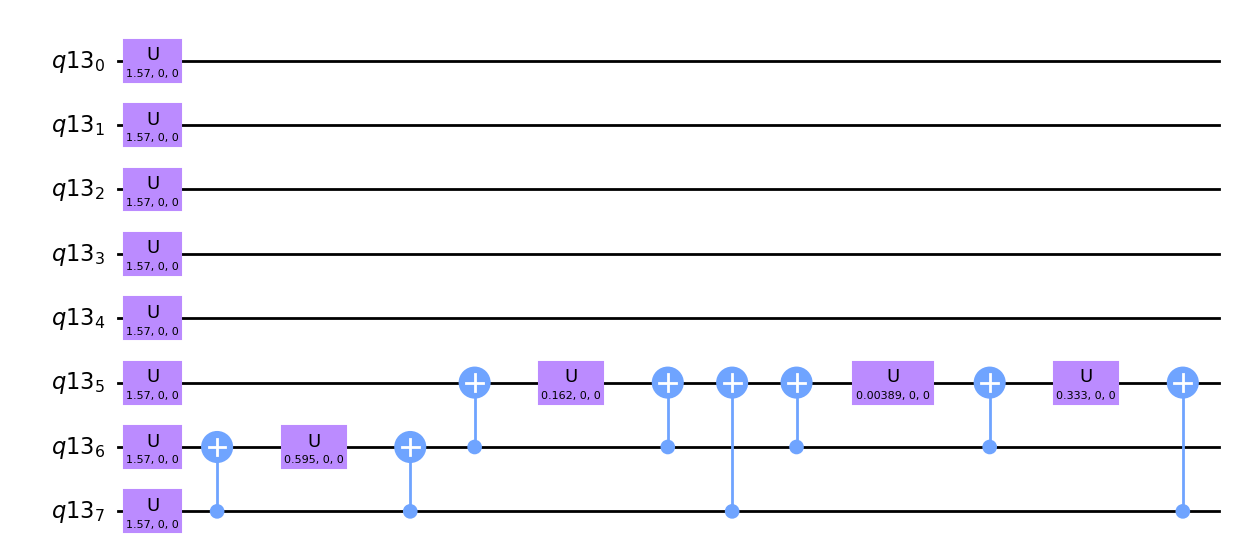

In [5]:
t_sanchez.draw("mpl", style="clifford")

/home/ismael/anaconda3/envs/sanchez-env/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ismael/anaconda3/envs/sanchez-env/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


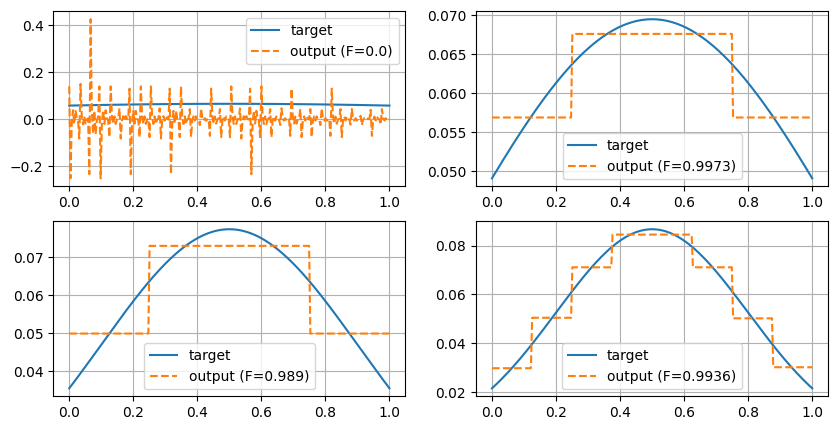

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

x_points = np.linspace(*interval, 2**num_qubits)

axes = axes.reshape(-1)

for (ax, targ_state, approx_state) in zip(axes, target_states, approx_states):
    fid = np.abs(targ_state @ approx_state)**2
    ax.plot(x_points, targ_state, label="target")
    ax.plot(x_points, approx_state, "--", label=f"output (F={np.round(fid, 4)})")
    ax.grid()
    ax.legend(loc="best")

axes = axes.reshape(2, 2)

### Black-Scholes

In [27]:
interval = (-10, 10)

state_params = {"x_points": interval, "K": 45, "c": 3}

num_qubits = 5
x_points = np.linspace(0, 2**num_qubits, 2**num_qubits)
black_scholes_state = get_state(num_qubits, "black-scholes", state_params)

sanchez = SanchezAnsatz(black_scholes_state, eps=0.05)
init_params = sanchez.init_params
t_sanchez = transpile(sanchez, basis_gates=["u", "cx"])

em = ExperimentModule(t_sanchez, SPSA(maxiter=3000), target_state=black_scholes_state, init_params=init_params,  device="GPU")


res = em.minimize()

t_sanchez = t_sanchez.assign_parameters(res.x)

result_sv = get_state_vector(t_sanchez)

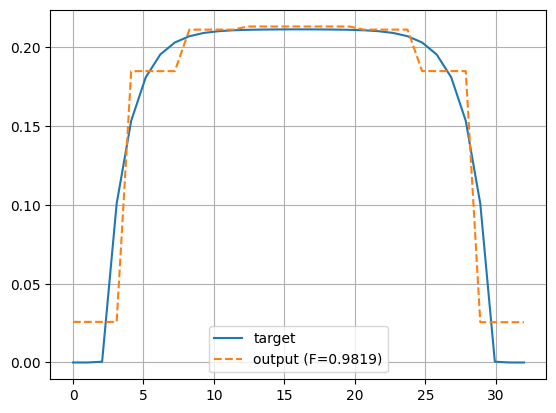

In [28]:
fid = np.abs(black_scholes_state @ result_sv)**2

plt.plot(x_points, black_scholes_state, label="target")
plt.plot(x_points, result_sv, "--", label=f"output (F={np.round(fid, 4)})")
plt.grid()
plt.legend(loc="best")
plt.show()
